In [1]:
import collections, math, os, sys
sys.path.insert(0, '../../../../FISH-annotation/Annotation')
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
from sklearn.neighbors import KDTree
from matplotlib.lines import Line2D
import util
import pandas as pd
import matplotlib.pyplot as plt

# Objective
Compare the effects of SNR and NND on detection, using the "Fig 2b" dataset.

Use median and quartiles as the metric for seeing how the distribution of NND in detected vs non-detected populations changes with respect to SNR.

# Takeaways

Trends using median and quartiles for the SNR vs. NND bin plot

From the scatter plots (one for each value of mean SNR for all images in the dataset), we can trivially observe that the prevalence of undetected (magenta) spots decreases when the median SNR increases.

From the individual strip plots and especially the plots showing the mean NND of undetected and detected spots for each SNR bin, we can observe that as spot SNR increases, median NND of undetected spots decreases. So at lower SNR, crowded spots are less likely to be detected. This is as expected.

In [2]:
density_list = [0.0025, 0.0027, 0.003, 0.0037, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
clustering_params = ['AffinityPropagation', -350]
correctness_threshold = 4
declumping_params = ['KMeans', 2]
height = 300


## Scatter plots

In [3]:
data_list = []
for mean_snr in [5, 7, 9]:
    data = []
    cwd = os.getcwd() + '/snr_' + str(mean_snr)
    json_paths = [cwd + '/anno/Fig2B_snr' + str(mean_snr) + '.json',
                  cwd + '/anno/Fig2B_snr' + str(mean_snr) + '_inv.json']

    # for each file
    for json_path in json_paths:

        # for each image
        for density in density_list:
            print(density)

            if(json_path == json_paths[0]):
                img_name = 'snr_' + str(mean_snr) + '_1_density_' + str(density) + '_spot_img.png'
                img_path = cwd + '/spot_images/og/' + img_name
            else:
                img_name = 'snr_' + str(mean_snr) + '_1_density_' + str(density) + '_spot_img_inv.png'
                img_path = cwd + '/spot_images/inv/' + img_name

            csv_path = cwd + '/spot_data/' + 'snr_' + str(mean_snr) + '_1_density_' + str(density) + '_coord_snr_list.csv'

            """ Get cluster centroids """
            qa = QuantiusAnnotation(json_path, img_name)
            anno_all = qa.df()
            sa = SpotAnnotationAnalysis(qa)

            clusters = sa.get_clusters(anno_all, clustering_params)
            cluster_size_threshold = util.get_cluster_size_threshold(clusters)
            small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
            clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
            clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
            result_clusters = nonclumpy_clusters
            for i in range(len(clumpy_clusters.index)):
                subclusters = util.declump(clumpy_clusters, i, declumping_params)
                result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

            """ Count up num_spots_detected, num_spots_total at each SNR """
            result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
            result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')

            ref_df = pd.read_csv(csv_path)
            ref_points = ref_df.loc[:, ['col', 'row']].as_matrix()
            ref_snrs = ref_df.loc[:, ['snr']].as_matrix()
            ref_kdt = KDTree(ref_points, leaf_size=2, metric='euclidean')

            # for each spot in the image
            for ref_point, ref_snr in zip(ref_points, ref_snrs):
                dist, ind = ref_kdt.query([ref_point], k=2)
                ref_nnd = dist[0][1]
                ref_snr = ref_snr[0]

                dist, ind = result_kdt.query([[ref_point[0], height-ref_point[1]]], k=1)
                if dist[0][0] <= correctness_threshold:
                    color = 'green'
                else:
                    color = 'magenta'

                data.append((ref_nnd, ref_snr, color))
    data_list.append(data)           
    

0.0025
0.0027
0.003
0.0037
0.004
0.005
0.006
0.007
0.008
0.009
0.0025
0.0027
0.003
0.0037
0.004
0.005
0.006
0.007
0.008
0.009
0.0025
0.0027
0.003
0.0037
0.004
0.005
0.006
0.007
0.008
0.009
0.0025
0.0027
0.003
0.0037
0.004
0.005
0.006
0.007
0.008
0.009
0.0025
0.0027
0.003
0.0037
0.004
0.005
0.006
0.007
0.008
0.009
0.0025
0.0027
0.003
0.0037
0.004
0.005
0.006
0.007
0.008
0.009


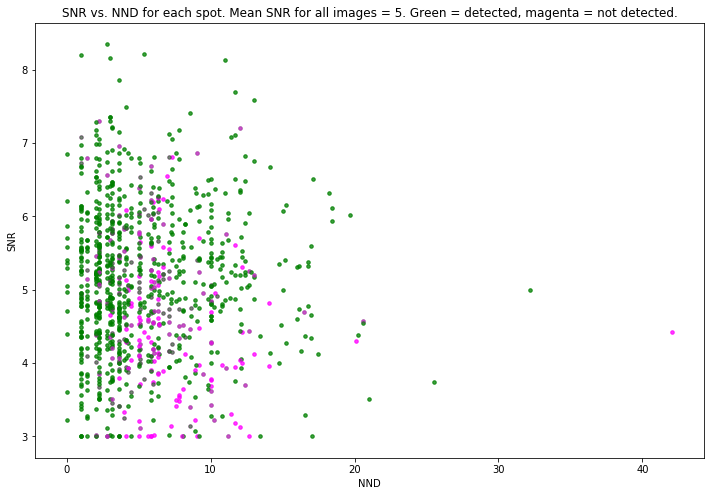

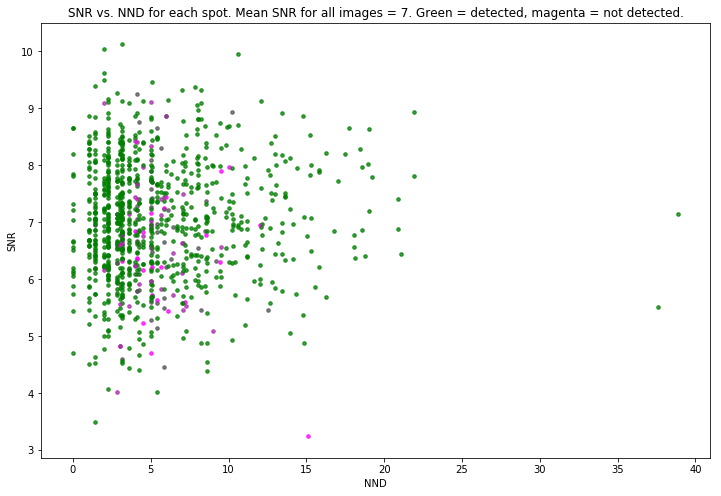

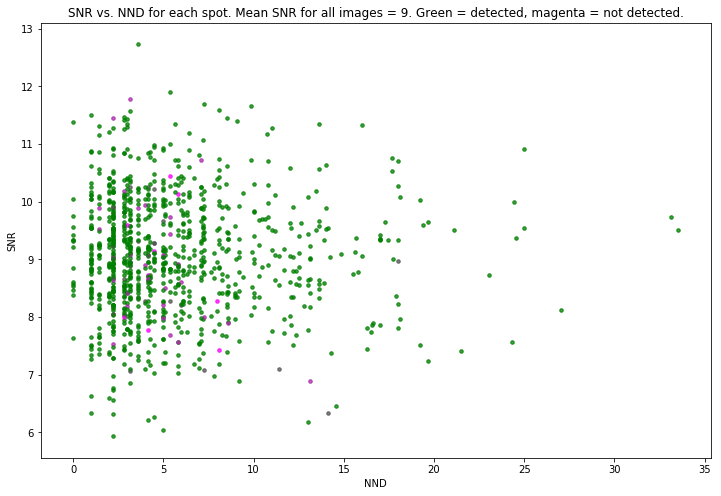

In [4]:
for data, mean_snr in zip(data_list, [5, 7, 9]):
    fig = plt.figure(figsize = (12,8))
    for ref_nnd, ref_snr, color in data:
        plt.scatter([ref_nnd], [ref_snr], color=color, alpha=0.5, s=12)
    plt.xlabel('NND')
    plt.ylabel('SNR')
    plt.title('SNR vs. NND for each spot. Mean SNR for all images = ' + str(mean_snr) + '. Green = detected, magenta = not detected.')
    plt.show()

## Strip plots and median NND for each bin

For each dataset (mean SNR of image = [5, 7, 9].

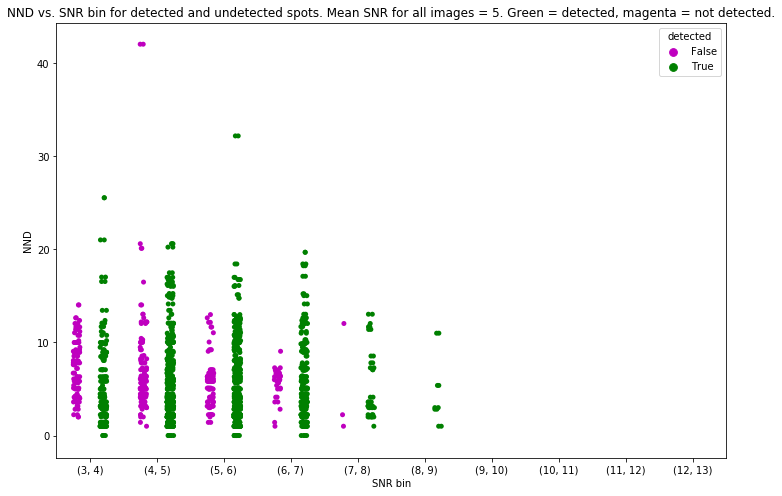

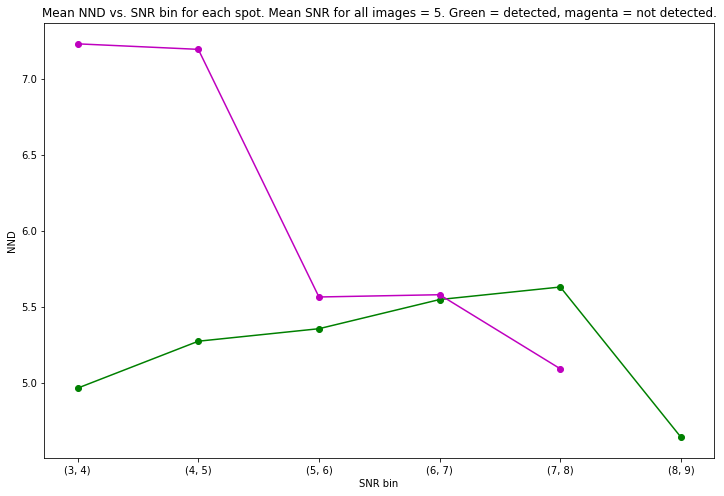

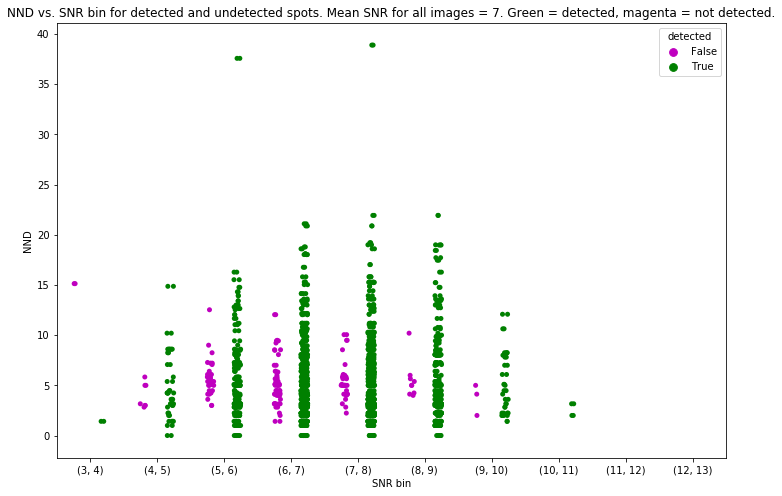

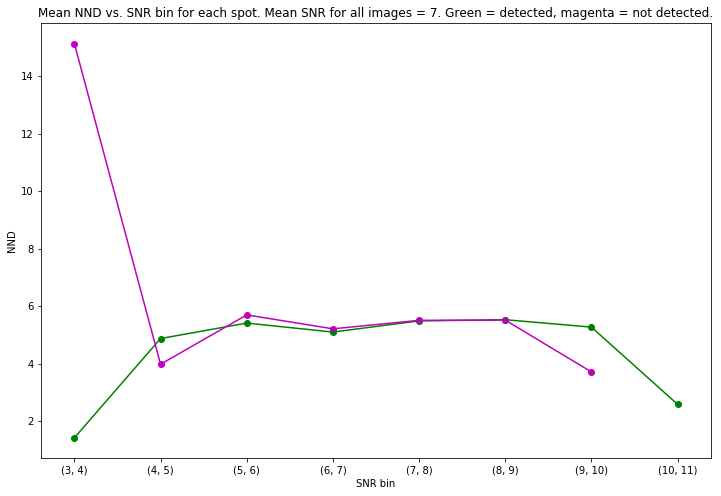

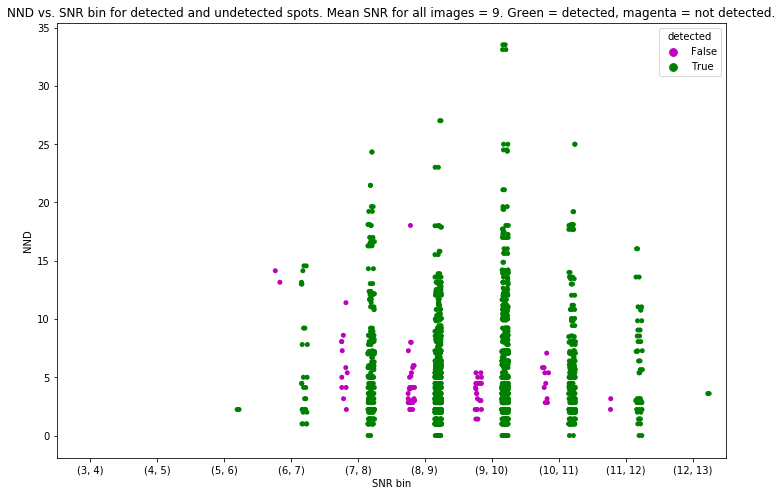

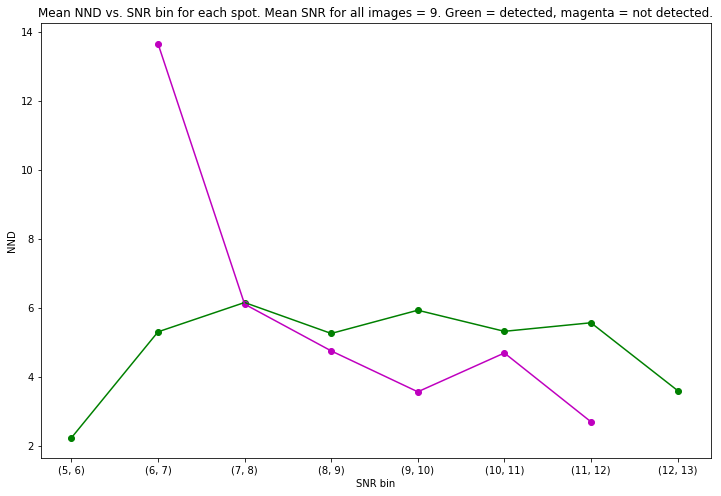

In [5]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
import seaborn as sns
import numpy as np

total_df = pd.DataFrame({'SNR':[],'NND':[], 'detected':[]})
for data, mean_snr in zip(data_list, [5, 7, 9]):
    nnd_list, snr_list, detected_list = [], [], []

    snr_bins = [(x, y) for x, y in zip(range(3, 13, 1), range(4, 14, 1)) ] 

    for ref_nnd, ref_snr, color in data:
        nnd_list.append(ref_nnd)
        detected_list.append(color=='green')

    ref_snr_max = 0
    for ref_nnd, ref_snr, color in data:
        for i in range(len(snr_bins)):
            low, high = snr_bins[i]
            if (ref_snr >= low and ref_snr < high):
                snr_list.append(str(snr_bins[i]))

    d = {'SNR':snr_list,'NND':nnd_list, 'detected':detected_list}
    df = pd.DataFrame(d)
    total_df = pd.concat([total_df, df], ignore_index=True)
    snr_bin_list = [str(x) for x in snr_bins]

    # plot strip plot
    fig = plt.figure(figsize = (12,8))
    sns.stripplot(x="SNR", y="NND", data=df, order=snr_bin_list, hue="detected", jitter=True, palette=sns.color_palette(['m','g']), dodge=True)
    plt.title('NND vs. SNR bin for detected and undetected spots. Mean SNR for all images = ' + str(mean_snr) + '. Green = detected, magenta = not detected.')
    plt.xlabel('SNR bin')
    plt.show()
    
    # plot mean NND of each bin
    fig = plt.figure(figsize = (12,8))
    mean_nnd_undetected, mean_nnd_detected, snr_bin_list_undetected, snr_bin_list_detected = [], [], [], []
    for nnd, snr_bin in zip(nnd_list, snr_bin_list):
        df_slice = df[df.SNR == snr_bin]
        
        df_undetected = df_slice[df_slice.detected == False]
        nnd_undetected = df_undetected['NND'].tolist()
        if len(nnd_undetected) != 0:
            mean_nnd_undetected.append(np.mean(nnd_undetected))
            snr_bin_list_undetected.append(snr_bin)
        
        df_detected = df_slice[df_slice.detected == True]
        nnd_detected = df_detected['NND'].tolist()
        if len(nnd_detected) != 0:
            mean_nnd_detected.append(np.mean(nnd_detected))
            snr_bin_list_detected.append(snr_bin)
        
    for snr, nnd in zip(snr_bin_list_detected, mean_nnd_detected):
        plt.scatter([snr], [nnd], color='g')       
    plt.plot(snr_bin_list_detected, mean_nnd_detected, color='g')
    plt.scatter(snr_bin_list_undetected, mean_nnd_undetected, color='m')
    plt.plot(snr_bin_list_undetected, mean_nnd_undetected, color='m')
    plt.xlabel('SNR bin')
    plt.ylabel('NND')
    plt.title('Mean NND vs. SNR bin for each spot. Mean SNR for all images = ' + str(mean_snr) + '. Green = detected, magenta = not detected.')



## Overall

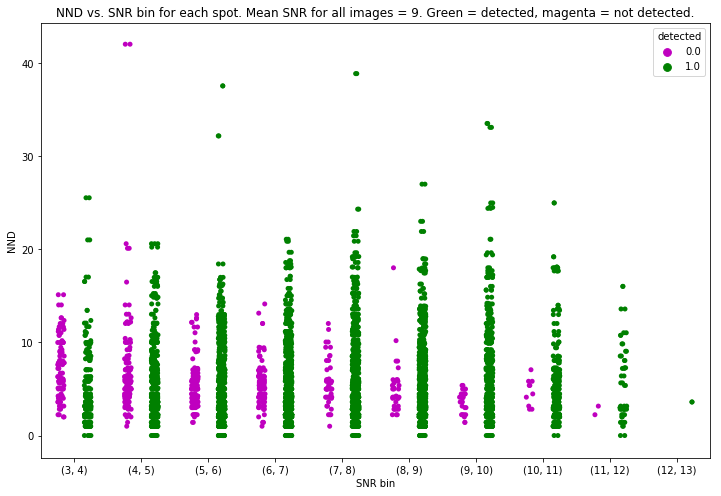

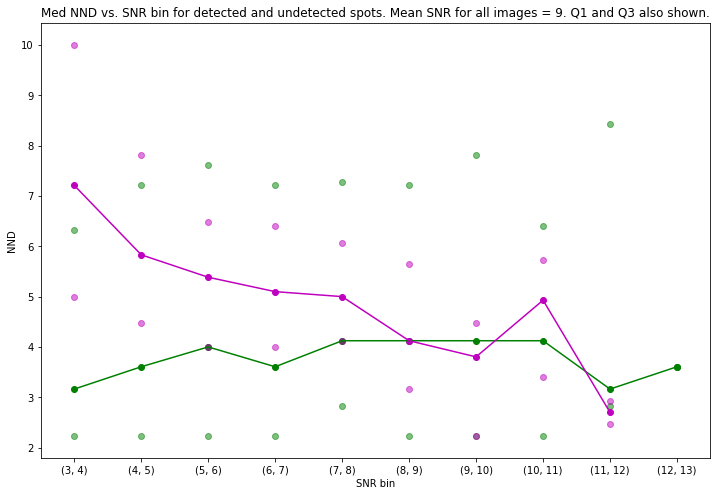

In [10]:
# plot strip plot
fig = plt.figure(figsize = (12,8))
sns.stripplot(x="SNR", y="NND", data=total_df, order=snr_bin_list, hue="detected", jitter=True, palette=sns.color_palette(['m','g']), dodge=True)
plt.title('NND vs. SNR bin for each spot. Mean SNR for all images = ' + str(mean_snr) + '. Green = detected, magenta = not detected.')
plt.xlabel('SNR bin')
plt.show()

# plot med NND of each bin
fig = plt.figure(figsize = (12,8))
q1_nnd_undetected, q1_nnd_detected, q3_nnd_undetected, q3_nnd_detected, med_nnd_undetected, med_nnd_detected, snr_bin_list_undetected, snr_bin_list_detected = [], [], [], [], [], [], [], []
for nnd, snr_bin in zip(nnd_list, snr_bin_list):
    df_slice = total_df[total_df.SNR == snr_bin]

    df_undetected = df_slice[df_slice.detected == False]
    nnd_undetected = df_undetected['NND'].tolist()
    if len(nnd_undetected) != 0:
        med_nnd_undetected.append(np.median(nnd_undetected))
        q1_nnd_undetected.append(np.percentile(nnd_undetected, 25))
        q3_nnd_undetected.append(np.percentile(nnd_undetected, 75))
        snr_bin_list_undetected.append(snr_bin)

    df_detected = df_slice[df_slice.detected == True]
    nnd_detected = df_detected['NND'].tolist()
    if len(nnd_detected) != 0:
        med_nnd_detected.append(np.median(nnd_detected))
        q1_nnd_detected.append(np.percentile(nnd_detected, 25))
        q3_nnd_detected.append(np.percentile(nnd_detected, 75))
        snr_bin_list_detected.append(snr_bin)

for snr, nnd in zip(snr_bin_list_detected, med_nnd_detected):
    plt.scatter([snr], [nnd], color='g')       
plt.plot(snr_bin_list_detected, med_nnd_detected, color='g')
plt.scatter(snr_bin_list_detected, q1_nnd_detected, color='g', alpha=0.5)
plt.scatter(snr_bin_list_detected, q3_nnd_detected, color='g', alpha=0.5)

plt.scatter(snr_bin_list_undetected, med_nnd_undetected, color='m')
plt.plot(snr_bin_list_undetected, med_nnd_undetected, color='m')
plt.scatter(snr_bin_list_undetected, q1_nnd_undetected, color='m', alpha=0.5)
plt.scatter(snr_bin_list_undetected, q3_nnd_undetected, color='m', alpha=0.5)

plt.xlabel('SNR bin')
plt.ylabel('NND')
plt.title('Med NND vs. SNR bin for detected and undetected spots. Mean SNR for all images = ' + str(mean_snr) + '. Q1 and Q3 also shown.')
plt.show()